# Import Packages

In [3]:
# Install huffman library if it isn't installed on your device
!pip install huffman

In [4]:
from matplotlib import image
import cv2 as cv
from scipy.fftpack import dct, idct
import huffman
from collections import Counter
# The line imports both matplotlin.pyplot and numpy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# `1.`Read Image and transform its color space

### 1.1 Read image

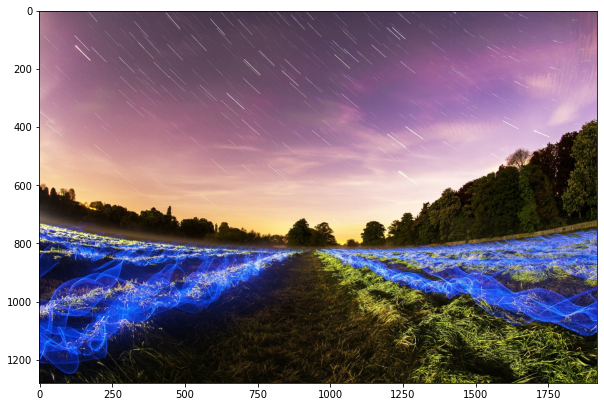

In [64]:
img = image.imread('tiff_1.tiff')
figure(figsize=(10,10))
imshow(img)
savefig('1.png')
show()

In [65]:
# Set quantization table side to be 8*8
side = 8 
side = max(2,min(8,side))

# Dimention of the image (No. pixels)
x_length = img.shape[1]//side
y_length = img.shape[0]//side

runBits = 1 
bitBits = 3 

##(run,bitSize of coefficient)
rbBits = runBits+bitBits

### 1.2 Convert image from RGB to YCbCr

In [66]:
def color_conversion(image, conversion):
    ''' Color conversion of image from rgb to YCbCr or vice versa '''
    
    delta = np.full(image.shape[:2], 128)

    if image.max() < 255.0:
        image = np.uint8(image * 255)
    
    if conversion == 'YCbCr':
        Y  = 0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2]
        Cb = 0.564*(image[:,:,2] - Y) + delta
        Cr = 0.713*(image[:,:,0] - Y) + delta

        return (np.dstack((Y, Cb, Cr))).astype(np.uint8)

    elif conversion == 'RGB':
        R = (image[:,:,0] + 1.402*(image[:,:,2]-delta)).clip(0,255)
        G = (image[:,:,0] - 0.344*(image[:,:,1]-delta) - 0.714*(image[:,:,1] - delta)).clip(0,255)
        B = (image[:,:,0] + 1.772*(image[:,:,1]-delta)).clip(0,255)

        return (np.dstack((R, G, B))).astype(np.uint8)

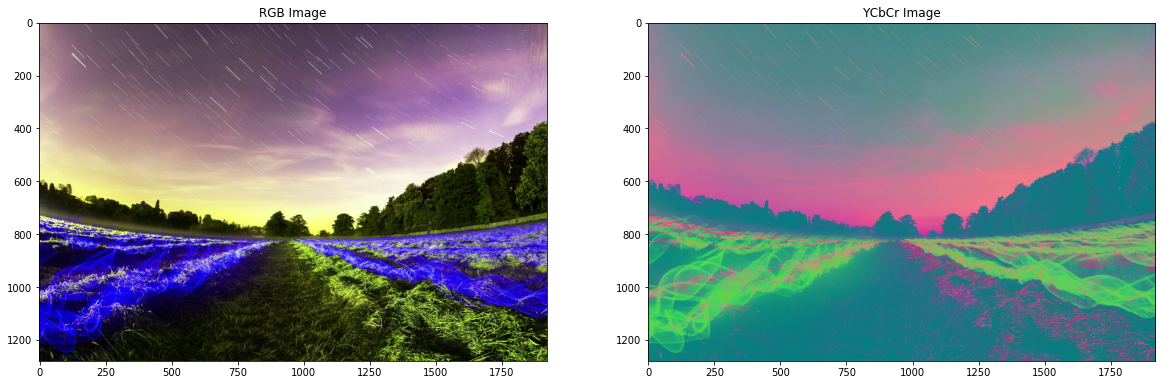

In [67]:
original_img = copy(img)

ycbcr = color_conversion(img, 'YCbCr')
rgb   = color_conversion(ycbcr, 'RGB')

figure(figsize=(20,20))
subplot(121)
imshow(rgb)
title('RGB Image')

subplot(122)
imshow(ycbcr)
title('YCbCr Image')
savefig('2.jpg')
show()

# `2.`Transform the image into blocks

### 2.1 Function to divide image into blocks

In [70]:
def dividing_into_blocks(image):
    blocks = zeros((y_length, x_length, side, side, 3), dtype=int16)

    for y in range(y_length):
        for x in range(x_length):
            blocks[y][x] = image[y*side:(y+1)*side, x*side:(x+1)*side]

    # Subtracting 128 from each pixel value to make them zero-centered
    blocks = array(blocks)
    
    return array(blocks)

In [71]:
# Creating new arrays with divided blocks
rgb_blocks   = dividing_into_blocks(img)
ycbcr_blocks = dividing_into_blocks(ycbcr)

# `3.`Discrete Cosine Transform (DCT)


### 3.1 Apply DCT on all the image blocks

In [72]:
def DCT(blocks, type="dct"):
    if type=="dct":
        function = dct
    else:
        function = idct
    
    dct_blocks = zeros((y_length, x_length, side, side,3))

    for y in range(y_length):
        for x in range(x_length):
            dct_temp = zeros((side, side, 3))

            for i in range(3):
                block=blocks[y][x][:,:,i]
                dct_temp[:,:,i] = function(function(block.T, norm = 'ortho').T, norm = 'ortho')
                
                if (type != "dct"):
                    dct_temp = dct_temp.round().astype(int16)
            
            dct_blocks[y][x] = dct_temp
    
    return dct_blocks

In [73]:
# Creating the array of DCT blocks of the image
DCT_blocks = DCT(ycbcr_blocks, "dct")

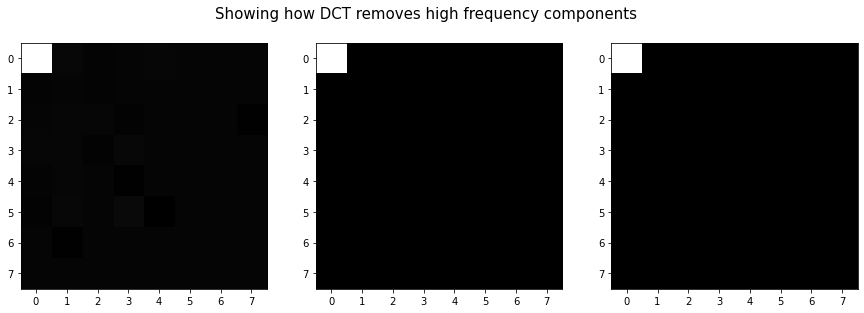

In [74]:
#DCT example of one DCT block
def DCT_example(block):
    figure(figsize=(15,15))
    suptitle('Showing how DCT removes high frequency components', y=0.65, fontsize=15)
    # Luminance
    subplot(1,3,1)
    imshow(block[0][0][:,:,0],cmap='gray')

    # Blue Chrominance
    subplot(1,3,2)
    imshow(block[0][0][:,:,1],cmap='gray')

    # Red chrominance
    subplot(1,3,3)
    imshow(block[0][0][:,:,2],cmap='gray')
    savefig('3.jpg')
    show()
    
DCT_example(DCT_blocks)

# `4.`Quantization of DCT Blocks


### 4.1 Quantization tables to quantize all dct blocks

In [76]:
#Quantization Table
# Luminance Quatization Table
Y_Q = array([[16,11,10,16,24,40,51,61],
          [12,12,14,19,26,58,60,55],
          [14,13,16,24,40,57,69,56],
          [14,17,22,29,51,87,80,62],
          [18,22,37,56,68,109,103,77],
          [24,35,55,64,81,104,113,92],
          [49,64,78,87,103,121,120,101],
          [72,92,95,98,112,100,103,99]])

# Chorminance Quatization Table
C_Q = array([[17,18,24,47,99,99,99,99],
           [18,21,26,66,99,99,99,99],
           [24,26,56,99,99,99,99,99],
           [47,66,99,99,99,99,99,99],
           [99,99,99,99,99,99,99,99],
           [99,99,99,99,99,99,99,99],
           [99,99,99,99,99,99,99,99],
           [99,99,99,99,99,99,99,99]])

Y_Q = Y_Q[:side, :side]
C_Q = C_Q[:side, :side]


Q_DCT_blocks = copy(DCT_blocks)

Q3 = moveaxis(array([Y_Q]+[C_Q]+[C_Q]),0,2)
Q3 = Q3*((11-side)/3)

Q_DCT_blocks = (Q_DCT_blocks/Q3).round().astype('int16') 

### 4.2 Image Reconstruction of 3 kinds 

In [77]:
def blocks_to_image(blocks):
    ''' Function to reconstruct the image from blocks'''
    Width = x_length * side
    Height = y_length * side

    reconstructed_image = zeros((Height, Width, 3))
    for y in range(y_length):
        for x in range(x_length):
            reconstructed_image[y*side:y*side+side, x*side:x*side+side] = blocks[y][x]
  
    return reconstructed_image

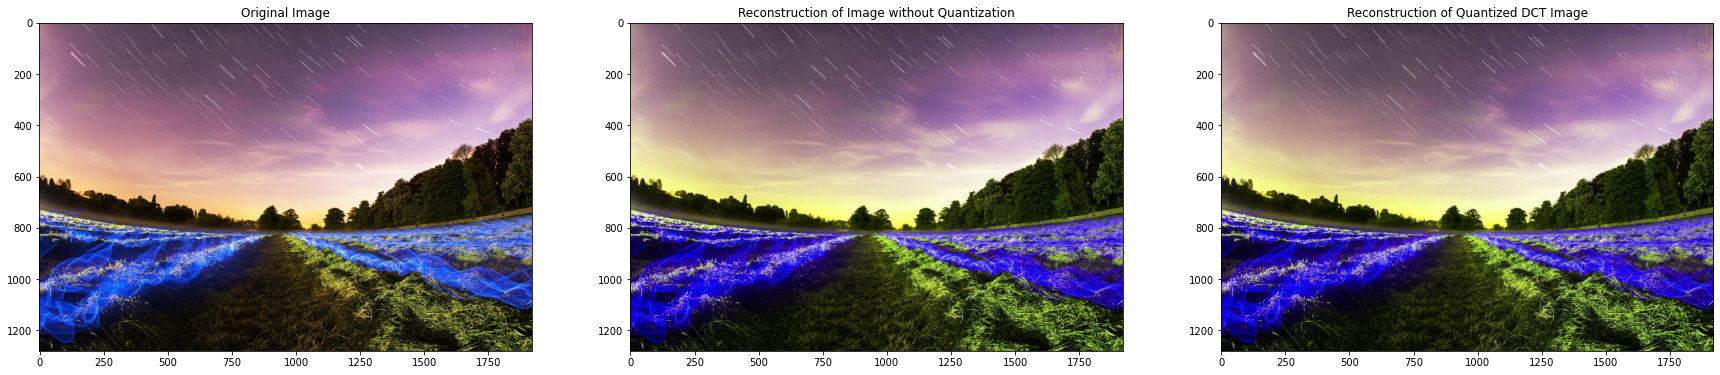

In [78]:
Reconstruct_DCT_image = DCT(DCT_blocks,"idct")
Reconstruct_DCT_image = blocks_to_image(Reconstruct_DCT_image)
Reconstruct_DCT_image = color_conversion(Reconstruct_DCT_image, 'RGB')

Reconstruct_Q_DCT_image = DCT(Q_DCT_blocks*Q3, 'idct')
Reconstruct_Q_DCT_image = blocks_to_image(Reconstruct_Q_DCT_image)
Reconstruct_Q_DCT_image = color_conversion(Reconstruct_Q_DCT_image, 'RGB')

figure(figsize=(30,30))
subplot(1,3,1)
title("Original Image")
imshow(original_img)

subplot(1,3,2)
title("Reconstruction of Image without Quantization")
imshow(Reconstruct_DCT_image)

subplot(1,3,3)
title("Reconstruction of Quantized DCT Image")
imshow(Reconstruct_Q_DCT_image)
savefig('4.jpg')
show()

### `Notice` There is hardly any difference between the images

# `5.`Demonstration of saving a quantized DCT block


### 5.1 Zig-Zag process

In [79]:
def ZigZag(block):
  result = [[] for i in range(side+side-1)] 
  for y in range(side): 
    for x in range(side): 
      i = y + x 
      if(i%2 == 0): 
          result[i].insert(0,block[y][x]) 
      else:  
          result[i].append(block[y][x]) 
  
  return array([coefficient for line in result for coefficient in line])

example = Q_DCT_blocks[0][0][:,:,0]
print('Example of an 8×8 block before ZigZag:')
print(example, '\n')

print('Example of an 8×8 block after ZigZag:')
print(ZigZag(example))

Example of an 8×8 block before ZigZag:
[[72  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]] 

Example of an 8×8 block after ZigZag:
[72  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


### 5.2 Huffman Coding

In [80]:
def huffman_counter(zigzag_array):
    rbCount=[]
    run=0
    for AC in zigzag_array[1:]:
        if(AC!=0):
            AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
            if(run>2**runBits-1):
                runGap=2**runBits
                k=run//runGap
                for i in range(k):
                    rbCount.append('1'*runBits+'0'*bitBits)
                run-=k*runGap
            run=min(run,2**runBits-1) 
            bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
            rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
            run=0
        else:
          run+=1
    rbCount.append("0"*(rbBits))
    
    return Counter(rbCount)

rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffman_counter(ZigZag(Q_DCT_blocks[0][0][:,:,0]))
rbCount[1]=huffman_counter(ZigZag(Q_DCT_blocks[0][0][:,:,1]))
rbCount[2]=huffman_counter(ZigZag(Q_DCT_blocks[0][0][:,:,2]))
rbCount=sum(rbCount)

print("Counter for Huffman Coding:\n"+str(rbCount))
print("\nHuffman Coding:\n"+str(huffman.codebook(rbCount.items())))

Counter for Huffman Coding:
Counter({'0000': 3, '0001': 1})

Huffman Coding:
{'0001': '0', '0000': '1'}


### 5.3 Run-Length encoding

In [81]:
def run_length(zigzag_array,last_DC,hfm=None):
    rlc = []
    run = 0
    new_DC = min(zigzag_array[0],2**(2**bitBits-1))
    DC = new_DC - last_DC

    bitSize=max(0,min(int(ceil(log(abs(DC)+0.000000001)/log(2))),2**bitBits-1))
    code=format(bitSize, '0'+str(bitBits)+'b')
    if (bitSize>0):
        code+=(format(DC,"b") if DC>0 else ''.join([str((int(b)^1)) for b in format(abs(DC),"b")]))
  
    for AC in zigzag_array[1:]:
        if(AC!=0):
            AC = max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
        
            if(run>2**runBits-1):
                runGap = 2**runBits
                k = run//runGap
                
                for i in range(k):
                    code += ('1'*runBits+'0'*bitBits)if hfm == None else  hfm['1'*runBits+'0'*bitBits]#end

                run -= k*runGap
    
            run = min(run,2**runBits-1) 
            bitSize = min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
            rb = format(run<<bitBits|bitSize,'0'+str(rbBits)+'b') if hfm == None else hfm[format(run<<bitBits|bitSize,'0'+str(rbBits)+'b')]
            code += rb+(format(AC,"b") if AC>=0 else ''.join([str((int(b)^1)) for b in format(abs(AC),"b")]))
            run = 0
            
        else:
            run += 1
    code += "0"*(rbBits) if hfm == None else  hfm["0"*(rbBits)]#end
    
    return code, new_DC

In [82]:
code_1,DC = run_length(ZigZag(Q_DCT_blocks[0][0][:,:,0]),0)
code_2,DC = run_length(ZigZag(Q_DCT_blocks[0][0][:,:,1]),DC)
code_3,DC = run_length(ZigZag(Q_DCT_blocks[0][0][:,:,2]),DC)

code_block_example = code_1 + code_2 + code_3

print('Size Comparisson before and after zig-zag & run length:\n')
print('Block Example:\n', code_block_example)
print("\nOriginal size of this block: " + str(side*side*3) +" KB"+
      "\nAfter Compresion size of this block: " + str(len(code_block_example)/8) +' KB')

Size Comparisson before and after zig-zag & run length:

Block Example:
 11110010000001100001000010000010011000000

Original size of this block: 192 KB
After Compresion size of this block: 5.125 KB


### 5.4 Transforming Run-Length to bytes

In [83]:
def run_length_to_bytes(code):
    return bytes([len(code)%8]+[int(code[i:i+8],2) for i in range(0, len(code), 8)])

In [84]:
#Example of saving and loading process of a block
print('Block Example:\n', code_block_example)

print("\nEncoding: split by length 8: ")
print(str([code_block_example[i:i+8] for i in range(0, len(code_block_example), 8)]))

print("\nTransfer to int8: ")
print(str([int(code_block_example[i:i+8],2) for i in range(0, len(code_block_example), 8)]))

code_to_bytes = run_length_to_bytes(code_block_example)
print("\nSave as bytes: \n" , str(code_to_bytes))
print("\nDecoding: load as int8: \n", str(list(code_to_bytes)))
print("\nTransfer to bytes(binary):\n", str([format(i,'08b') for i in list(code_to_bytes)]))

bytes_to_code = "".join([format(i,'08b') for i in list(code_to_bytes)])
print("\nJoining them:\n", bytes_to_code)

Block Example:
 11110010000001100001000010000010011000000

Encoding: split by length 8: 
['11110010', '00000110', '00010000', '10000010', '01100000', '0']

Transfer to int8: 
[242, 6, 16, 130, 96, 0]

Save as bytes: 
 b'\x01\xf2\x06\x10\x82`\x00'

Decoding: load as int8: 
 [1, 242, 6, 16, 130, 96, 0]

Transfer to bytes(binary):
 ['00000001', '11110010', '00000110', '00010000', '10000010', '01100000', '00000000']

Joining them:
 00000001111100100000011000010000100000100110000000000000


# `6.`Saving the image, repeating step-5 for all blocks of the image

In [85]:
def huffman_counter_full_image(blocks):
    rb_count = zeros(x_length*y_length*3, dtype=Counter)
    zz = zeros(x_length*y_length*3,dtype=object)
    for y in range(y_length):
        for x in range(x_length):
            for i in range(3):
                zz[y*x_length*3+x*3+i]=ZigZag(blocks[y, x,:,:,i])
                rb_count[y*x_length*3+x*3+i]=huffman_counter(zz[y*x_length*3+x*3+i])

    return sum(rb_count), zz

In [86]:
rb_count, zz = huffman_counter_full_image(Q_DCT_blocks)
hfm = huffman.codebook(rb_count.items())
sorted_huffman = [[hfm[i[0]],i[0],rb_count[i[0]]] for i in rb_count.most_common()]

print('Most common patterns in the image:')
sorted_huffman

Most common patterns in the image:


[['11', '0001', 211051],
 ['00', '1000', 138548],
 ['101', '0000', 115200],
 ['100', '0010', 87678],
 ['011', '1001', 86333],
 ['0101', '0011', 41347],
 ['01000', '1010', 15193],
 ['010011', '0100', 14990],
 ['0100100', '1011', 3800],
 ['01001011', '0101', 3072],
 ['010010101', '1100', 872],
 ['0100101001', '0110', 298],
 ['01001010001', '1101', 97],
 ['01001010000', '1110', 6]]

In [87]:
print('Size comparison before & after huffman encoding:')
print("Size before huffman encoding: "+str(sum(array(rb_count.most_common(),dtype=int32)[:,1]*rbBits)/8/2**10) + " KB")
print("Size after huffman encoding: "+str(sum([rb_count[k]*len(v) for k,v in hfm.items()])/8/2**10) + " KB")

Size comparison before & after huffman encoding:
Size before huffman encoding: 350.82275390625 KB
Size after huffman encoding: 239.4117431640625 KB


In [88]:
def saving_image(blocks):
    rbCount, zigzag = huffman_counter_full_image(blocks)
    hfm = huffman.codebook(rbCount.items())
    sorted_huffman = [[hfm[i[0]],i[0]] for i in rbCount.most_common()]
    code=""
    DC=0
    for y in range(y_length):
        for x in range(x_length):
            for i in range(3):
                code_new, DC = run_length(zigzag[y*x_length*3+x*3+i],DC,hfm)
                code += code_new
    saved_image = run_length_to_bytes(code)
    
    print("Image original size:    %.3f MB"%(img.size/(2**20)))
    print("Compressed image size: %.3f MB"%(len(saved_image)/2**20))
    print("Compression ratio:      %.2f : 1"%(img.size/2**20/(len(saved_image)/2**20)))

    return bytes([int(format(x_length,'012b')[:8],2),int(format(x_length,'012b')[8:]+format(y_length,'012b')[:4],2),int(format(y_length,'012b')[4:],2)])+saved_image, sorted_huffman

In [89]:
saved_image, sorted_huffman_for_decode = saving_image(Q_DCT_blocks)

save = open("img.bin", "wb")
save.write(saved_image)
save.close()

Image original size:    7.031 MB
Compressed image size: 0.421 MB
Compression ratio:      16.70 : 1


In [91]:
matplotlib.image.imsave('compressed_image.jpg', Reconstruct_Q_DCT_image)